# TensorFlow的机制

## TensorFlow的关键特征

是可以利用单个或多个GPU进行工作

## TensorFlow 秩和张量

![Tensor](1.png)

### 如何获取tensor的秩和形状 

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np

g = tf.Graph()
# define the computation graph
with g.as_default():
    # define tensors t1, t2, t3
    t1 = tf.constant(np.pi)
    t2 = tf.constant([1, 2, 3, 4])
    t3 = tf.constant([[1, 2], [3, 4]])
    
    # get their ranks
    r1 = tf.rank(t1)
    r2 = tf.rank(t2)
    r3 = tf.rank(t3)
    
    # get their shapes
    s1 = t1.get_shape()
    s2 = t2.get_shape()
    s3 = t3.get_shape()
    print('Shapes:', s1, s2, s3)

Shapes: () (4,) (2, 2)


In [3]:
with tf.Session(graph=g) as sess:
    print('Ranks:', r1.eval(), r2.eval(), r3.eval())

Ranks: 0 1 2


## 理解TensorFlow的计算图

In [4]:
g = tf.Graph()
with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    
    z = 2*(a-b) + c

In [8]:
with tf.Session(graph=g) as sess:
    print('2*(a-b)+c =', sess.run(z))

2*(a-b)+c = 1


## TensorFlow中的Placeholders

### 定义Placeholders

In [11]:
import tensorflow as tf

g = tf.Graph()
with g.as_default():
    tf_a = tf.placeholder(tf.int32, shape=[], name='tf_a')
    tf_b = tf.placeholder(tf.int32, shape=[], name='tf_b')
    tf_c = tf.placeholder(tf.int32, shape=[], name='tf_c')
    
    r1 = tf_a - tf_b
    r2 = 2*r1
    z = r2 + tf_c

### 喂给placeholders数据

In [12]:
with tf.Session(graph=g) as sess:
    feed = {tf_a: 1, tf_b: 2, tf_c: 3}
    print('z:',sess.run(z, feed_dict=feed))

z: 1


### 为具有不同批处理大小的数据阵列定义placeholders

In [15]:
import tensorflow as tf

g = tf.Graph()
with g.as_default():
    tf_x = tf.placeholder(tf.float32, shape=[None, 2], name='tf_x')
    x_mean = tf.reduce_mean(tf_x, axis=0, name='mean')

In [16]:
import numpy as np
np.random.seed(123)
np.set_printoptions(precision=2)
with tf.Session(graph=g) as sess:
    x1 = np.random.uniform(low=0, high=1, size=(5, 2))
    print('Feeding data with shape',x1.shape)
    print('Result:',sess.run(x_mean, feed_dict={tf_x: x1}))
    
    x2 = np.random.uniform(low=0, high=1, size=(10, 2))
    print('Feeding data with shape',x2.shape)
    print('Result:',sess.run(x_mean, feed_dict={tf_x: x2}))

Feeding data with shape (5, 2)
Result: [0.62 0.47]
Feeding data with shape (10, 2)
Result: [0.46 0.49]


## TensorFlow的变量

### 定义变量

In [22]:
import tensorflow as tf
import numpy as np

g1 = tf.Graph()
with g1.as_default():
    w = tf.Variable(np.array([[1, 2, 3, 4],
                              [5, 6, 7, 8]], dtype=np.int64), name='w')
    print(w)

<tf.Variable 'w:0' shape=(2, 4) dtype=int64_ref>


### 初始化变量

In [23]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(w))

[[1 2 3 4]
 [5 6 7 8]]


In [24]:
# 定义在Graph内部的initializer
import tensorflow as tf

g2 = tf.Graph()
with g2.as_default():
    w1 = tf.Variable(1, name='w1')
    init_op = tf.global_variables_initializer()
    w2 = tf.Variable(2, name='w2')

In [25]:
with tf.Session(graph=g2) as sess:
    sess.run(init_op)
    print('w1: ', sess.run(w1))

w1:  1


In [27]:
with tf.Session(graph=g2) as sess:
    sess.run(init_op)
    print('w2: ', sess.run(w2))

FailedPreconditionError: Attempting to use uninitialized value w2
	 [[{{node _retval_w2_0_0}}]]

根据上述,initializer需要定义在所有变量之后

### 变量范围

In [28]:
import tensorflow as tf
g = tf.Graph()

with g.as_default():
    with tf.variable_scope('net_A'):
        with tf.variable_scope('layer-1'):
            w1 = tf.Variable(tf.random_normal(shape=(10, 4)), name='weights')
        with tf.variable_scope('layer-2'):
            w2 = tf.Variable(tf.random_normal(shape=(20, 10)), name='weights')
    
    with tf.variable_scope('net_B'):
        with tf.variable_scope('layer-1'):
            w3 = tf.Variable(tf.random_normal(shape=(10, 4)), name='weights')
    
    print(w1)
    print(w2)
    print(w3)

<tf.Variable 'net_A/layer-1/weights:0' shape=(10, 4) dtype=float32_ref>
<tf.Variable 'net_A/layer-2/weights:0' shape=(20, 10) dtype=float32_ref>
<tf.Variable 'net_B/layer-1/weights:0' shape=(10, 4) dtype=float32_ref>


### 重用变量

In [39]:
import tensorflow as tf


######################
## Helper functions ##
######################

def build_classifier(data, labels, n_classes=2):
    data_shape = data.get_shape().as_list()
    weights = tf.get_variable(name='weights', shape=(data_shape[1], n_classes), dtype=tf.float32)
    bias = tf.get_variable(name='bias', initializer=tf.zeros(shape=n_classes))
    logits = tf.add(tf.matmul(data, weights), bias, name='logits')
    return logits, tf.nn.softmax(logits)

def build_generator(data, n_hidden):
    data_shape = data.get_shape().as_list()
    w1 = tf.Variable(tf.random_normal(shape=(data_shape[1], n_hidden)), name='w1')
    b1 = tf.Variable(tf.zeros(shape=n_hidden), name='b1')
    hidden = tf.add(tf.matmul(data, w1), b1, name='hidden_pre-activation')
    hidden = tf.nn.relu(hidden, 'hidden_activation')
    
    w2 = tf.Variable(tf.random_normal(shape=(n_hidden, data_shape[1])), name='w2')
    b2 = tf.Variable(tf.zeros(shape=data_shape[1]), name='b2')
    output = tf.add(tf.matmul(hidden, w2), b2, name='output')
    return output, tf.nn.sigmoid(output)
    

In [40]:
########################
## Defining the graph ##
########################

batch_size = 64
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), dtype=tf.float32, name='tf_X')
    # build the generator
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    # build the classifier
    with tf.variable_scope('classifier') as scope:
        # classifier for the original data
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        # reuse the classifier for generated data
        scope.reuse_variables()
        cls_out2 = build_classifier(data=gen_out1[1], labels=tf.zeros(shape=batch_size))
        

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), dtype=tf.float32, name='tf_X')
    # build the generator
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    # build the classifier
    with tf.variable_scope('classifier'):
        # classifier for the original data
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
    
    with tf.variable_scope('classifier', reuse=True):
        # reuse the classifier for generated data
        cls_out2 = build_classifier(data=gen_out1[1], labels=tf.zeros(shape=batch_size))

## 建立一个回归模型

In [2]:
import tensorflow as tf
import numpy as np

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(123)
    # placeholders
    tf_x = tf.placeholder(shape=(None), dtype=tf.float32, name='tf_x')
    tf_y = tf.placeholder(shape=(None), dtype=tf.float32, name='tf_y')
    # define the variable (model parameters)
    weight = tf.Variable(tf.random_normal(shape=(1, 1), stddev=0.25), name='weight')
    bias = tf.Variable(0.0, name='bias')
    # build the model
    y_hat = tf.add(weight*tf_x, bias, name='y_hat')
    # compute the cost
    cost = tf.reduce_mean(tf.square(tf_y - y_hat), name='cost')
    # train the model
    optim = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optim.minimize(cost, name='train_op')
    

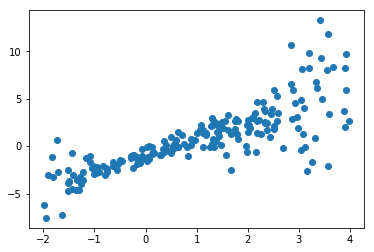

In [13]:
# create a random toy dataset for regression
import matplotlib.pyplot as plt
np.random.seed(123)

def make_random_data():
    x = np.random.uniform(low=-2, high=4, size=200)
    y = []
    for t in x:
        r = np.random.normal(loc=0.0, scale=(0.5 + t*t/3), size=None)
        y.append(r)
    return x, 1.726*x - 0.84 + np.array(y)

x, y = make_random_data()
plt.plot(x, y, 'o')

In [15]:
# train/test splits
x_train, y_train = x[:100], y[:100]
x_test, y_test = x[100:], y[100:]

n_epochs = 500
training_costs = []
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    # train the model for n_epochs
    for e in range(n_epochs):
        c, _ = sess.run([cost, train_op], feed_dict={tf_x:x_train, tf_y:y_train})
        training_costs.append(c)
        if not e % 50:
            print('Epoch {:4}: {:.4}'.format(e, c))

Epoch    0: 10.59
Epoch   50: 6.876
Epoch  100: 5.008
Epoch  150: 4.05
Epoch  200: 3.54
Epoch  250: 3.253
Epoch  300: 3.08
Epoch  350: 2.966
Epoch  400: 2.884
Epoch  450: 2.821


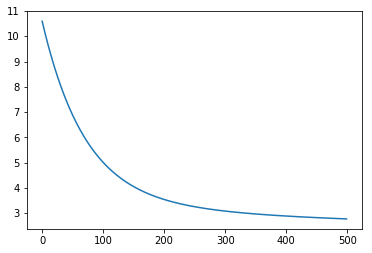

In [16]:
plt.plot(training_costs)

## 使用名字在TensorFlow图中运行objects